[View in Colaboratory](https://colab.research.google.com/github/bt22dr/deep-learning-papers/blob/master/code/sngan_fashion_mnist.ipynb)

# SNGAN fashion MNIST
*  기존  [gan 코드](https://github.com/bt22dr/deep-learning-papers/blob/master/code/gan_fashion_mnist.ipynb)를 기반으로 sngan 코드([1](https://github.com/minhnhat93/tf-SNDCGAN), [2](https://github.com/nnUyi/SNGAN))를 참고하여 SNGAN를 구현함.
*   아래 [4]번 셀의 url로 Tensorboard에 접속하여 학습 과정(생성 이미지, loss) 변화를 확인할 수 있다.

In [1]:
%matplotlib inline

import os
import sys
import time

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfd = tf.contrib.distributions
layers = tf.keras.layers

tf.enable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Found GPU at: /device:GPU:0
TensorFlow version: 1.9.0-rc2
Eager execution: True


In [2]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2018-07-10 16:52:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.80.190, 52.87.35.92, 54.152.208.69, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.80.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-07-10 16:52:40 (45.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [4]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ce24ae6c.ngrok.io


In [0]:
!rm -rf checkpoints/ log/

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

4423680/4422102 [==============================] - 3s 1us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


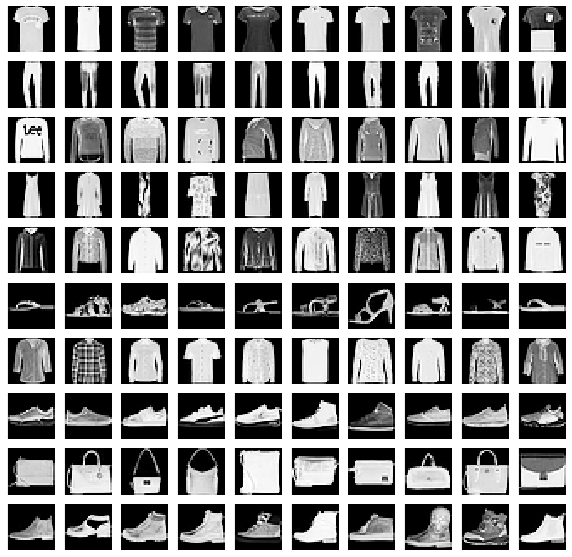

In [7]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

for i, ax_row in enumerate(axes):
  imgs = x_test[np.where(y_test == i)[0][:10]]
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(imgs[j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [0]:
from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import standard_ops

# Spectral Normalization GAN 구현은 
# https://github.com/nnUyi/SNGAN/blob/master/ops.py 이곳을 참조했음.

def l2_norm(input_x, epsilon=1e-12):
    input_x_norm = input_x / (tf.reduce_sum(input_x ** 2) ** 0.5 + epsilon)
    return input_x_norm
    
def weights_spectral_norm(weights, u=None):
  w_shape = weights.get_shape().as_list()
  w_mat = tf.reshape(weights, [-1, w_shape[-1]])

  if u is None:
      u = tf.get_variable(
          'u', shape=[1, w_shape[-1]], 
          initializer=tf.truncated_normal_initializer(), trainable=False)

  def power_iteration(u, ite=1):
      v_ = tf.matmul(u, tf.transpose(w_mat))
      v_hat = l2_norm(v_)
      u_ = tf.matmul(v_hat, w_mat)
      u_hat = l2_norm(u_)
      return u_hat, v_hat, ite + 1

  u_hat, v_hat, _ = power_iteration(u)
  sigma = tf.matmul(tf.matmul(v_hat, w_mat), tf.transpose(u_hat))

  w_mat = w_mat / sigma
  
  with tf.control_dependencies([u.assign(u_hat)]):
      w_norm = tf.reshape(w_mat, w_shape)
      
  return w_norm

class Conv2D_SN(layers.Conv2D):
  def __init__(self, *args, **kwargs):
    super(Conv2D_SN, self).__init__(*args, **kwargs)

  def call(self, inputs):
      weights = self.kernel
      w_norm = weights_spectral_norm(weights)

      outputs = self._convolution_op(inputs, w_norm)

      if self.data_format == 'channels_first':
          outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
      else:
          outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')

      if self.activation is not None:
          return self.activation(outputs)
      return outputs

class Dense_SN(layers.Dense):
  def __init__(self, *args, **kwargs):
    super(Dense_SN, self).__init__(*args, **kwargs)

  def call(self, inputs):
    weights = self.kernel
    w_norm = weights_spectral_norm(weights)
    
    inputs = ops.convert_to_tensor(inputs, dtype=self.dtype)
    shape = inputs.get_shape().as_list()
    
    if len(shape) > 2:
      # Broadcasting is required for the inputs.
      outputs = standard_ops.tensordot(inputs, w_norm, [[len(shape) - 1],
                                                             [0]])
      # Reshape the output back to the original ndim of the input.
      if not context.executing_eagerly():
        output_shape = shape[:-1] + [self.units]
        outputs.set_shape(output_shape)
    else:
      outputs = gen_math_ops.mat_mul(inputs, w_norm)
    if self.use_bias:
      outputs = nn.bias_add(outputs, self.bias)
    if self.activation is not None:
      return self.activation(outputs)  # pylint: disable=not-callable
    return outputs

In [0]:
class Discriminator(tf.keras.Model):
  """GAN Discriminator.
  A network to differentiate between generated and real handwritten digits.
  """

  def __init__(self, data_format):
    """Creates a model for discriminating between real and generated digits.
    Args:
      data_format: Either 'channels_first' or 'channels_last'.
        'channels_first' is typically faster on GPUs while 'channels_last' is
        typically faster on CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    """
    super(Discriminator, self).__init__(name='')
    if data_format == 'channels_first':
      self._input_shape = [-1, 1, 28, 28]
    else:
      assert data_format == 'channels_last'
      self._input_shape = [-1, 28, 28, 1]
    self.conv1 = Conv2D_SN(
        64, 5, padding='SAME', data_format=data_format, activation=None)
    self.bn1 = layers.BatchNormalization(momentum=0.8)
    self.ac1 = layers.LeakyReLU(alpha=0.2)
    self.pool1 = layers.AveragePooling2D(2, 2, data_format=data_format)
    self.conv2 = Conv2D_SN(
        128, 5, data_format=data_format, activation=None)
    self.bn2 = layers.BatchNormalization(momentum=0.8)
    self.ac2 = layers.LeakyReLU(alpha=0.2)
    self.pool2 = layers.AveragePooling2D(2, 2, data_format=data_format)
    self.flatten = layers.Flatten()
    self.fc1 = Dense_SN(1024, activation=tf.nn.leaky_relu)
    self.fc2 = Dense_SN(1, activation=None)

  def call(self, inputs):
    """Return two logits per image estimating input authenticity.
    Users should invoke __call__ to run the network, which delegates to this
    method (and not call this method directly).
    Args:
      inputs: A batch of images as a Tensor with shape [batch_size, 28, 28, 1]
        or [batch_size, 1, 28, 28]
    Returns:
      A Tensor with shape [batch_size] containing logits estimating
      the probability that corresponding digit is real.
    """
    
    x = tf.reshape(inputs, self._input_shape)
    x = self.conv1(x)
    x = self.ac1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.ac2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [0]:
class Generator(tf.keras.Model):
  """Generator of handwritten digits similar to the ones in the MNIST dataset.
  """

  def __init__(self, data_format):
    """Creates a model for discriminating between real and generated digits.
    Args:
      data_format: Either 'channels_first' or 'channels_last'.
        'channels_first' is typically faster on GPUs while 'channels_last' is
        typically faster on CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    """
    super(Generator, self).__init__(name='')
    self.data_format = data_format
    # We are using 128 6x6 channels as input to the first deconvolution layer
    if data_format == 'channels_first':
      self._pre_conv_shape = [-1, 512, 3, 3]
    else:
      assert data_format == 'channels_last'
      self._pre_conv_shape = [-1, 3, 3, 512]
    self.fc1 = layers.Dense(3 * 3 * 512, activation=tf.nn.leaky_relu)

    # In call(), we reshape the output of fc1 to _pre_conv_shape

    # Deconvolution layer. Resulting image shape: (batch, 7, 7, 512)
    self.conv1 = layers.Conv2DTranspose(
        512, 3, strides=2, activation=None, data_format=data_format)
    self.bn1 = layers.BatchNormalization()
    self.ac1 = layers.LeakyReLU(alpha=0.2)

    # Deconvolution layer. Resulting image shape: (batch, 14, 14, 128)
    self.conv2 = layers.Conv2DTranspose(
        128, 2, strides=2, activation=None, data_format=data_format)
    self.bn2 = layers.BatchNormalization()
    self.ac2 = layers.LeakyReLU(alpha=0.2)
    
    # Deconvolution layer. Resulting image shape: (batch, 28, 28, 1)
    self.conv3 = layers.Conv2DTranspose(
        1, 2, strides=2, activation=tf.nn.sigmoid, data_format=data_format)

  def call(self, inputs):
    """Return a batch of generated images.
    Users should invoke __call__ to run the network, which delegates to this
    method (and not call this method directly).
    Args:
      inputs: A batch of noise vectors as a Tensor with shape
        [batch_size, length of noise vectors].
    Returns:
      A Tensor containing generated images. If data_format is 'channels_last',
      the shape of returned images is [batch_size, 28, 28, 1], else
      [batch_size, 1, 28, 28]
    """

    x = self.fc1(inputs)
    x = tf.reshape(x, shape=self._pre_conv_shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.ac1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.ac2(x)
    x = self.conv3(x)
    return x

In [0]:
# dummy_noise = tf.random_uniform(shape=[1,100], minval=-1., maxval=1.)
# dummy_g = Generator('channels_first')
# dummy_d = Discriminator('channels_first')
# dummy_d(dummy_g(dummy_noise))

# print(dummy_g.summary())
# print(dummy_d.summary())

In [0]:
def discriminator_loss(discriminator_real_outputs, discriminator_gen_outputs):
  """Original discriminator loss for GANs, with label smoothing.
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661) for more
  details.
  Args:
    discriminator_real_outputs: Discriminator output on real data.
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
  Returns:
    A scalar loss Tensor.
  """

  loss_on_real = tf.losses.sigmoid_cross_entropy(
      tf.ones_like(discriminator_real_outputs),
      discriminator_real_outputs,
      label_smoothing=0.1)
  loss_on_generated = tf.losses.sigmoid_cross_entropy(
      tf.zeros_like(discriminator_gen_outputs), discriminator_gen_outputs)
  loss = loss_on_real + loss_on_generated
  tf.contrib.summary.scalar('discriminator_loss', loss)
  return loss


def generator_loss(discriminator_gen_outputs):
  """Original generator loss for GANs.
  L = -log(sigmoid(D(G(z))))
  See `Generative Adversarial Nets` (https://arxiv.org/abs/1406.2661)
  for more details.
  Args:
    discriminator_gen_outputs: Discriminator output on generated data. Expected
      to be in the range of (-inf, inf).
  Returns:
    A scalar loss Tensor.
  """
  loss = tf.losses.sigmoid_cross_entropy(
      tf.ones_like(discriminator_gen_outputs), discriminator_gen_outputs)
  tf.contrib.summary.scalar('generator_loss', loss)
  return loss

In [0]:
def train_one_epoch(generator, discriminator, generator_optimizer,
                    discriminator_optimizer, dataset, step_counter,
                    log_interval, noise_dim):
  """Trains `generator` and `discriminator` models on `dataset`.
  Args:
    generator: Generator model.
    discriminator: Discriminator model.
    generator_optimizer: Optimizer to use for generator.
    discriminator_optimizer: Optimizer to use for discriminator.
    dataset: Dataset of images to train on.
    step_counter: An integer variable, used to write summaries regularly.
    log_interval: How many steps to wait between logging and collecting
      summaries.
    noise_dim: Dimension of noise vector to use.
  """

  total_generator_loss = 0.0
  total_discriminator_loss = 0.0
  for (batch_index, images) in enumerate(tfe.Iterator(dataset)):
    with tf.device('/cpu:0'):
      tf.assign_add(step_counter, 1)

    with tf.contrib.summary.record_summaries_every_n_global_steps(
        log_interval, global_step=step_counter):
      current_batch_size = images.shape[0]
      noise = tf.random_uniform(
          shape=[current_batch_size, noise_dim],
          minval=-1.,
          maxval=1.,
          seed=batch_index)

      with tf.GradientTape(persistent=True) as g:
        generated_images = generator(noise)
        tf.contrib.summary.image(
            'generated_images',
            tf.reshape(generated_images, [-1, 28, 28, 1]),
            max_images=10)

        discriminator_gen_outputs = discriminator(generated_images)
        discriminator_real_outputs = discriminator(images)
        discriminator_loss_val = discriminator_loss(discriminator_real_outputs,
                                                    discriminator_gen_outputs)
        total_discriminator_loss += discriminator_loss_val

        generator_loss_val = generator_loss(discriminator_gen_outputs)
        total_generator_loss += generator_loss_val

      generator_grad = g.gradient(generator_loss_val, generator.variables)
      discriminator_grad = g.gradient(discriminator_loss_val,
                                      discriminator.variables)

      generator_optimizer.apply_gradients(
          zip(generator_grad, generator.variables))
      discriminator_optimizer.apply_gradients(
          zip(discriminator_grad, discriminator.variables))

      if log_interval and batch_index > 0 and batch_index % log_interval == 0:
        print('Batch #%d\tAverage Generator Loss: %.6f\t'
              'Average Discriminator Loss: %.6f' %
              (batch_index, total_generator_loss / batch_index,
               total_discriminator_loss / batch_index))

In [0]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument(
    '--data-dir',
    type=str,
    default='/tmp/tensorflow/mnist/input_data',
    help=('Directory for storing input data (default '
          '/tmp/tensorflow/mnist/input_data)'))
parser.add_argument(
    '--batch-size',
    type=int,
    default=128,
    metavar='N',
    help='input batch size for training (default: 128)')
parser.add_argument(
    '--log-interval',
    type=int,
    default=100,
    metavar='N',
    help=('number of batches between logging and writing summaries '
          '(default: 100)'))
parser.add_argument(
    '--output_dir',
    type=str,
    default='log',
    metavar='DIR',
    help='Directory to write TensorBoard summaries (defaults to none)')
parser.add_argument(
    '--checkpoint_dir',
    type=str,
    default='./checkpoints/',
    metavar='DIR',
    help=('Directory to save checkpoints in (once per epoch) (default '
          '/tmp/tensorflow/mnist/checkpoints/)'))
parser.add_argument(
    '--lr',
    type=float,
    default=0.0001,
    metavar='LR',
    help='learning rate (default: 0.0001)')
parser.add_argument(
    '--noise',
    type=int,
    default=100,
    metavar='N',
    help='Length of noise vector for generator input (default: 100)')
parser.add_argument(
    '--no-gpu',
    action='store_true',
    default=False,
    help='disables GPU usage even if a GPU is available')

FLAGS, unparsed = parser.parse_known_args()

In [15]:
(device, data_format) = ('/gpu:0', 'channels_first')
if FLAGS.no_gpu or tfe.num_gpus() <= 0:
  (device, data_format) = ('/cpu:0', 'channels_last')
print('Using device %s, and data format %s.' % (device, data_format))

# Load the datasets
dataset = (
    tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000) # TODO: keras ImageDataGenerator 사용
    .batch(FLAGS.batch_size))

# Create the models and optimizers.
model_objects = {
    'generator': Generator(data_format),
    'discriminator': Discriminator(data_format),
    'generator_optimizer': tf.train.AdamOptimizer(FLAGS.lr),
    'discriminator_optimizer': tf.train.AdamOptimizer(FLAGS.lr),
    'step_counter': tf.train.get_or_create_global_step(),
}

# Prepare summary writer and checkpoint info
summary_writer = tf.contrib.summary.create_summary_file_writer(
    FLAGS.output_dir, flush_millis=1000)
checkpoint_prefix = os.path.join(FLAGS.checkpoint_dir, 'ckpt')
latest_cpkt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
if latest_cpkt:
  print('Using latest checkpoint at ' + latest_cpkt)
checkpoint = tfe.Checkpoint(**model_objects)
# Restore variables on creation if a checkpoint exists.
checkpoint.restore(latest_cpkt)

with tf.device(device):
  for _ in range(100):
    start = time.time()
    with summary_writer.as_default():
      train_one_epoch(dataset=dataset, log_interval=FLAGS.log_interval,
                      noise_dim=FLAGS.noise, **model_objects)
    end = time.time()
    checkpoint.save(checkpoint_prefix)
    print('\nTrain time for epoch #%d (step %d): %f' %
          (checkpoint.save_counter.numpy(),
           checkpoint.step_counter.numpy(),
           end - start))

Using device /gpu:0, and data format channels_first.
Batch #100	Average Generator Loss: 2.734086	Average Discriminator Loss: 0.448274
Batch #200	Average Generator Loss: 2.380189	Average Discriminator Loss: 0.475069
Batch #300	Average Generator Loss: 2.809807	Average Discriminator Loss: 0.418796
Batch #400	Average Generator Loss: 3.142829	Average Discriminator Loss: 0.384691

Train time for epoch #1 (step 469): 114.925211
Batch #100	Average Generator Loss: 4.304075	Average Discriminator Loss: 0.298694
Batch #200	Average Generator Loss: 3.599309	Average Discriminator Loss: 0.363120
Batch #300	Average Generator Loss: 3.247242	Average Discriminator Loss: 0.430132
Batch #400	Average Generator Loss: 3.020928	Average Discriminator Loss: 0.479569

Train time for epoch #2 (step 938): 113.634877
Batch #100	Average Generator Loss: 2.112811	Average Discriminator Loss: 0.639914
Batch #200	Average Generator Loss: 2.093646	Average Discriminator Loss: 0.637670
Batch #300	Average Generator Loss: 1.9658


Train time for epoch #10 (step 4690): 114.377501
Batch #100	Average Generator Loss: 1.033196	Average Discriminator Loss: 1.161112
Batch #200	Average Generator Loss: 1.031655	Average Discriminator Loss: 1.166807
Batch #300	Average Generator Loss: 1.037064	Average Discriminator Loss: 1.170132
Batch #400	Average Generator Loss: 1.024631	Average Discriminator Loss: 1.168859

Train time for epoch #11 (step 5159): 114.914996
Batch #100	Average Generator Loss: 1.054119	Average Discriminator Loss: 1.169564
Batch #200	Average Generator Loss: 1.015937	Average Discriminator Loss: 1.185382
Batch #300	Average Generator Loss: 0.983008	Average Discriminator Loss: 1.194468
Batch #400	Average Generator Loss: 0.982936	Average Discriminator Loss: 1.201648

Train time for epoch #12 (step 5628): 114.731646
Batch #100	Average Generator Loss: 0.959955	Average Discriminator Loss: 1.280081
Batch #200	Average Generator Loss: 0.958086	Average Discriminator Loss: 1.241416
Batch #300	Average Generator Loss: 0.945

Batch #100	Average Generator Loss: 0.896836	Average Discriminator Loss: 1.287145
Batch #200	Average Generator Loss: 0.862491	Average Discriminator Loss: 1.291994
Batch #300	Average Generator Loss: 0.858278	Average Discriminator Loss: 1.296009
Batch #400	Average Generator Loss: 0.851524	Average Discriminator Loss: 1.297968

Train time for epoch #21 (step 9849): 115.291099
Batch #100	Average Generator Loss: 0.857311	Average Discriminator Loss: 1.289747
Batch #200	Average Generator Loss: 0.847503	Average Discriminator Loss: 1.285059
Batch #300	Average Generator Loss: 0.858867	Average Discriminator Loss: 1.286958
Batch #400	Average Generator Loss: 0.861346	Average Discriminator Loss: 1.288872

Train time for epoch #22 (step 10318): 115.238204
Batch #100	Average Generator Loss: 0.848571	Average Discriminator Loss: 1.301940
Batch #200	Average Generator Loss: 0.839036	Average Discriminator Loss: 1.292090
Batch #300	Average Generator Loss: 0.840517	Average Discriminator Loss: 1.290502
Batch #4

Batch #100	Average Generator Loss: 0.845588	Average Discriminator Loss: 1.315806
Batch #200	Average Generator Loss: 0.852420	Average Discriminator Loss: 1.310791
Batch #300	Average Generator Loss: 0.848096	Average Discriminator Loss: 1.304827
Batch #400	Average Generator Loss: 0.844732	Average Discriminator Loss: 1.304511

Train time for epoch #31 (step 14539): 114.943640
Batch #100	Average Generator Loss: 0.835049	Average Discriminator Loss: 1.327404
Batch #200	Average Generator Loss: 0.828174	Average Discriminator Loss: 1.317402
Batch #300	Average Generator Loss: 0.851361	Average Discriminator Loss: 1.310803
Batch #400	Average Generator Loss: 0.836983	Average Discriminator Loss: 1.309008

Train time for epoch #32 (step 15008): 115.352693
Batch #100	Average Generator Loss: 0.819666	Average Discriminator Loss: 1.318088
Batch #200	Average Generator Loss: 0.820803	Average Discriminator Loss: 1.307015
Batch #300	Average Generator Loss: 0.825683	Average Discriminator Loss: 1.306174
Batch #

Batch #100	Average Generator Loss: 0.815193	Average Discriminator Loss: 1.314886
Batch #200	Average Generator Loss: 0.827211	Average Discriminator Loss: 1.304865
Batch #300	Average Generator Loss: 0.821630	Average Discriminator Loss: 1.308111
Batch #400	Average Generator Loss: 0.829573	Average Discriminator Loss: 1.306292

Train time for epoch #41 (step 19229): 115.616180
Batch #100	Average Generator Loss: 0.872284	Average Discriminator Loss: 1.313727
Batch #200	Average Generator Loss: 0.833550	Average Discriminator Loss: 1.314269
Batch #300	Average Generator Loss: 0.827495	Average Discriminator Loss: 1.312074
Batch #400	Average Generator Loss: 0.835000	Average Discriminator Loss: 1.312605

Train time for epoch #42 (step 19698): 115.401666
Batch #100	Average Generator Loss: 0.856638	Average Discriminator Loss: 1.316005
Batch #200	Average Generator Loss: 0.829350	Average Discriminator Loss: 1.312610
Batch #300	Average Generator Loss: 0.827095	Average Discriminator Loss: 1.313395
Batch #

Batch #100	Average Generator Loss: 0.828962	Average Discriminator Loss: 1.330233
Batch #200	Average Generator Loss: 0.830792	Average Discriminator Loss: 1.318246
Batch #300	Average Generator Loss: 0.825245	Average Discriminator Loss: 1.314199
Batch #400	Average Generator Loss: 0.822997	Average Discriminator Loss: 1.315273

Train time for epoch #51 (step 23919): 115.841134
Batch #100	Average Generator Loss: 0.809656	Average Discriminator Loss: 1.329741
Batch #200	Average Generator Loss: 0.809665	Average Discriminator Loss: 1.316650
Batch #300	Average Generator Loss: 0.818750	Average Discriminator Loss: 1.318681
Batch #400	Average Generator Loss: 0.826606	Average Discriminator Loss: 1.315019

Train time for epoch #52 (step 24388): 115.558043
Batch #100	Average Generator Loss: 0.829452	Average Discriminator Loss: 1.313861
Batch #200	Average Generator Loss: 0.809385	Average Discriminator Loss: 1.320627
Batch #300	Average Generator Loss: 0.812087	Average Discriminator Loss: 1.319016
Batch #

Batch #100	Average Generator Loss: 0.822984	Average Discriminator Loss: 1.331533
Batch #200	Average Generator Loss: 0.826215	Average Discriminator Loss: 1.318679
Batch #300	Average Generator Loss: 0.818767	Average Discriminator Loss: 1.318947
Batch #400	Average Generator Loss: 0.820449	Average Discriminator Loss: 1.317758

Train time for epoch #61 (step 28609): 115.498102
Batch #100	Average Generator Loss: 0.855983	Average Discriminator Loss: 1.307315
Batch #200	Average Generator Loss: 0.823259	Average Discriminator Loss: 1.316260
Batch #300	Average Generator Loss: 0.826498	Average Discriminator Loss: 1.312496
Batch #400	Average Generator Loss: 0.820661	Average Discriminator Loss: 1.315205

Train time for epoch #62 (step 29078): 115.548892
Batch #100	Average Generator Loss: 0.796457	Average Discriminator Loss: 1.324859
Batch #200	Average Generator Loss: 0.805893	Average Discriminator Loss: 1.323363
Batch #300	Average Generator Loss: 0.806600	Average Discriminator Loss: 1.319600
Batch #

Batch #100	Average Generator Loss: 0.842945	Average Discriminator Loss: 1.292932
Batch #200	Average Generator Loss: 0.819076	Average Discriminator Loss: 1.310447
Batch #300	Average Generator Loss: 0.816207	Average Discriminator Loss: 1.314301
Batch #400	Average Generator Loss: 0.809074	Average Discriminator Loss: 1.315222

Train time for epoch #71 (step 33299): 115.029645
Batch #100	Average Generator Loss: 0.826357	Average Discriminator Loss: 1.330334
Batch #200	Average Generator Loss: 0.830159	Average Discriminator Loss: 1.322522
Batch #300	Average Generator Loss: 0.817405	Average Discriminator Loss: 1.321697
Batch #400	Average Generator Loss: 0.816632	Average Discriminator Loss: 1.319713

Train time for epoch #72 (step 33768): 115.349851
Batch #100	Average Generator Loss: 0.785074	Average Discriminator Loss: 1.337325
Batch #200	Average Generator Loss: 0.787123	Average Discriminator Loss: 1.330938
Batch #300	Average Generator Loss: 0.791318	Average Discriminator Loss: 1.326345
Batch #

Batch #100	Average Generator Loss: 0.822934	Average Discriminator Loss: 1.332810
Batch #200	Average Generator Loss: 0.818865	Average Discriminator Loss: 1.329856
Batch #300	Average Generator Loss: 0.817100	Average Discriminator Loss: 1.327875
Batch #400	Average Generator Loss: 0.816657	Average Discriminator Loss: 1.326316

Train time for epoch #81 (step 37989): 114.391667
Batch #100	Average Generator Loss: 0.808724	Average Discriminator Loss: 1.334271
Batch #200	Average Generator Loss: 0.797170	Average Discriminator Loss: 1.329281
Batch #300	Average Generator Loss: 0.797209	Average Discriminator Loss: 1.326002
Batch #400	Average Generator Loss: 0.802190	Average Discriminator Loss: 1.324209

Train time for epoch #82 (step 38458): 114.781876
Batch #100	Average Generator Loss: 0.831565	Average Discriminator Loss: 1.321795
Batch #200	Average Generator Loss: 0.815930	Average Discriminator Loss: 1.321176
Batch #300	Average Generator Loss: 0.819311	Average Discriminator Loss: 1.317200
Batch #

Batch #100	Average Generator Loss: 0.797840	Average Discriminator Loss: 1.341120
Batch #200	Average Generator Loss: 0.801848	Average Discriminator Loss: 1.335224
Batch #300	Average Generator Loss: 0.807562	Average Discriminator Loss: 1.329533
Batch #400	Average Generator Loss: 0.801343	Average Discriminator Loss: 1.329873

Train time for epoch #91 (step 42679): 115.073475
Batch #100	Average Generator Loss: 0.818714	Average Discriminator Loss: 1.338093
Batch #200	Average Generator Loss: 0.808662	Average Discriminator Loss: 1.329694
Batch #300	Average Generator Loss: 0.799413	Average Discriminator Loss: 1.329573
Batch #400	Average Generator Loss: 0.800094	Average Discriminator Loss: 1.326784

Train time for epoch #92 (step 43148): 114.710600
Batch #100	Average Generator Loss: 0.812824	Average Discriminator Loss: 1.329475
Batch #200	Average Generator Loss: 0.817810	Average Discriminator Loss: 1.326892
Batch #300	Average Generator Loss: 0.815071	Average Discriminator Loss: 1.319584
Batch #

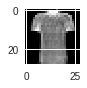

In [16]:
noise = np.random.random((1, FLAGS.noise))*2-1
generated_images = model_objects["generator"](noise)
generated_image = np.squeeze(generated_images.numpy())
plt.figure(figsize=(1,1))
plt.imshow(generated_image, cmap='gray')

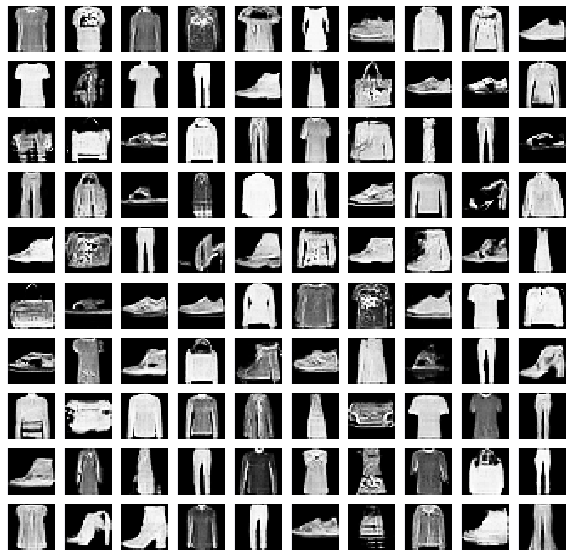

In [17]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharex=True, sharey=True)

noise = np.random.random((100, FLAGS.noise))*2-1
generated_images = model_objects["generator"](noise)
generated_images = np.squeeze(generated_images.numpy())

for i, ax_row in enumerate(axes):
  for j, ax in enumerate(ax_row):
    _ = ax.imshow(generated_images[i*10+j], cmap='Greys_r')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)